In [21]:
!pip3 install diffprivlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import psutil

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [22]:
start_time = time.time()
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)


In [23]:
dataset = raw_dataset.copy()

In [24]:
dataset = dataset.dropna()


In [25]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [26]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')


In [27]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


In [28]:
X_train = train_dataset.copy()
X_test = test_dataset.copy()

y_train = X_train.pop('MPG')
y_test = X_test.pop('MPG')


In [29]:
from sklearn.linear_model import LinearRegression as sk_LinearRegression

regr = Pipeline([
    ('scaler', Normalizer()), 
    ('clf', sk_LinearRegression()) 
])

regr.fit(X_train, y_train)

baseline = regr.score(X_test, y_test)
print("Non-private baseline R2 score: %.2f" % baseline)


Non-private baseline R2 score: 0.90


In [30]:
from diffprivlib.models import LinearRegression
dp_regr = Pipeline([
    ('scaler', Normalizer()), 
    ('clf', LinearRegression(epsilon=float('inf'))) 
])

dp_regr.fit(X_train, y_train)

baseline2 = dp_regr.score(X_test, y_test)
print("private baseline R2 score: %.2f" % baseline2)


private baseline R2 score: 0.90


/usr/local/lib/python3.7/dist-packages/diffprivlib/models/linear_regression.py:258: PrivacyLeakWarning: Bounds parameters haven't been specified, so falling back to determining bounds from the data.
This will result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `bounds_X` and `bounds_y`.
  PrivacyLeakWarning)


In [31]:
epsilons = np.logspace(-3, 2, 500)
accuracy = []
cpu_Overhead = []
mem_Overhead = []

for epsilon in epsilons:
    dp_regr.fit(X_train, y_train)

    cpu_Overhead.append(psutil.cpu_percent())
    psutil.virtual_memory()
    dict(psutil.virtual_memory()._asdict())
    mem_Overhead.append(psutil.virtual_memory().percent)   

    accuracy.append(dp_regr.score(X_test, y_test))

--- 19.162018537521362 seconds ---


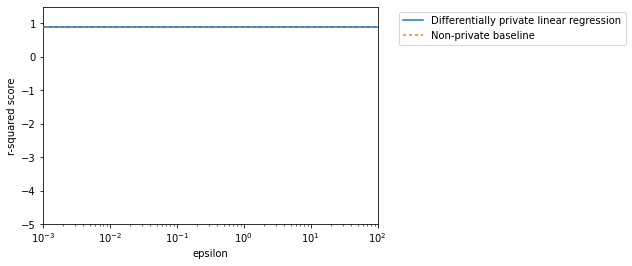

In [32]:
print("--- %s seconds ---" % (time.time() - start_time))
plt.semilogx(epsilons, accuracy, label="Differentially private linear regression", zorder=10)
plt.semilogx(epsilons, baseline * np.ones_like(epsilons), dashes=[2,2], label="Non-private baseline", zorder=5)
plt.xlabel("epsilon")
plt.ylabel("r-squared score")
plt.ylim(-5, 1.5)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [33]:
print(sum((cpu_Overhead))/500)
print(sum((mem_Overhead))/500)

51.339400000000005
6.400000000000056


In [34]:
accuracy_final1 = []
for _ in " "*10: 
  dp_regr.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final1.append(dp_regr.score(X_test, y_test))


In [35]:
accuracy_final01 = []
for _ in " "*10: 
  dp_regr.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final01.append(dp_regr.score(X_test, y_test))


In [36]:
accuracy_final001 = []
for _ in " "*10: 
  dp_regr.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final001.append(dp_regr.score(X_test, y_test))


In [37]:
accuracy_final = []
#accuracy_final1.remove(max(accuracy_final1))
#accuracy_final1.remove(min(accuracy_final1))

#accuracy_final01.remove(max(accuracy_final01))
#accuracy_final01.remove(min(accuracy_final01))

#accuracy_final001.remove(max(accuracy_final001))
#accuracy_final001.remove(min(accuracy_final001))

accuracy_final.append(sum(accuracy_final1)/10)
accuracy_final.append(sum(accuracy_final01)/10)
accuracy_final.append(sum(accuracy_final001)/10)

In [38]:
accuracy_final

[-1073904264.100863, -38258623.74527389, -26799806977.754467]

In [39]:
accuracy_NP = []
for _ in " "*10: 
  regr.fit(X_train, y_train) 
  accuracy_NP.append(regr.score(X_test, y_test))

In [40]:
print(sum(accuracy_NP)/10)

0.8954456598949074
